In [1]:
import os
import os.path as op
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats
from scipy.ndimage import measurements

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

import mne
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm
from mne.decoding import CSP
from library import helpers, config

In [2]:
# %%
def get_epos(subID, epo_part, signaltype, condition, event_dict):
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + epo_part +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed']:
        fname = op.join(config.path_epos_sorted, epo_part, signaltype,
                        subID + '-epo.fif')
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)

def get_sensordata(subID, epo_part, signaltype, conditions, event_dict):
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   epo_part=epo_part,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict)

    times = epos_dict[conditions[0]][0].copy().times

    # Setup data:
    X_epos = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
    n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X_epos, y, times_n


def load_avgtfr(subID, condition, pwr_style='induced', 
                part_epo='fulllength', baseline=None, mode=None): 
    fpath = op.join(config.path_tfrs, pwr_style, 'tfr_lists', part_epo)
    fname = op.join(fpath, subID + '-collapsed-avgTFRs-tfr.h5')
    tfr_ = mne.time_frequency.read_tfrs(fname, condition=condition)
    if baseline is not None:
        tfr_.apply_baseline(baseline=baseline, mode=mode)
    return tfr_


def plot_tfr_side(ax, tfr, picks, cbar=True, tmin=None, tmax=None, 
                  vmin=None, vmax=None, title='', cmap='RdBu'):
        ha = tfr.copy().crop(tmin, tmax).plot(axes=ax, 
                                      show=False, 
                                      colorbar=cbar,
                                      picks=picks, 
                                      combine='mean', 
                                      title=title, 
                                      vmax=vmax, 
                                      vmin=vmin, 
                                      cmap=cmap)
        ytick_range = ax.get_ylim()
        ytick_vals = np.arange(*np.round(ytick_range), 2)
        ax.yaxis.set_ticks(ytick_vals)
        ax.axvspan(0, 0.2, color='grey', alpha=0.3)
        ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
        ax.vlines((-0.8, 0, 0.2, 2.2), ymin=-1000, ymax=10000, linestyles='dashed')
        #ax.set_title('uV^2/Hz')
        return ha

def get_lateralized_power_difference(pwr_, picks_contra, picks_ipsi):
    if not len(picks_contra) == len(picks_ipsi):
        raise ValueError('Picks must be of same length.')
    pwr_diff = pwr_.copy().pick_channels(picks_contra, ordered=True)
    pwr_ordered_chans = pwr_.copy().reorder_channels(picks_contra + picks_ipsi)
    # keep flexible to use for data with 3 (AvgTFR) and 4 (EpoTFR) dimensions: 
    d_contra = pwr_ordered_chans._data[..., :len(picks_contra), :, :]
    d_ipsi = pwr_ordered_chans._data[..., len(picks_contra):, :, :]
    pwr_diff._data = d_contra - d_ipsi
    return pwr_diff


def run_cbp_test(data, p_initial = 0.05, p_thresh = 0.05):
    # number of permutations to run
    n_permutations = 1000 
    # set initial threshold
    p_initial = p_initial
    # set family-wise p-value
    p_thresh = p_thresh
    connectivity = None
    tail = 0.  # for two sided test

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = permutation_cluster_1samp_test(
        data, threshold=threshold, n_jobs=config.n_jobs, verbose=True, tail=tail,
        step_down_p=0.05, connectivity=connectivity,
        n_permutations=n_permutations, seed=42)

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return(T_obs, clusters, cluster_p_values)


def plot_cbp_result_cda(ax, T_obs, clusters, cluster_p_values, p_thresh, 
                        cbp_times=None, times_full=None):
    if cbp_times is None:
        if times_full is None: 
            times_full = range(len(T_obs))
        cbp_times = times_full
    if times_full is None: 
        times_full = cbp_times
    y_max = np.max(np.abs(T_obs)) * np.array([-1.1, 1.1])
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] < p_thresh:
            h1 = ax.axvspan(cbp_times[c.start], cbp_times[c.stop - 1],
                            color='r', alpha=0.3)
    hf = ax.plot(cbp_times, T_obs, 'g')
    ax.hlines(0, times_full[0], times_full[-1])
    ax.legend((h1,), (u'p < %s' % p_thresh,), loc='upper right', ncol=1, prop={'size': 9})
    ax.set(xlabel="Time (s)", ylabel="T-values",
            ylim=y_max, xlim=times_full[np.array([0,-1])])
    #fig.tight_layout(pad=0.5)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    ax.vlines([-0.8, 0,0.2,2.2], *y_max, linestyles='--', colors='k',
                    linewidth=1., zorder=1)
    #ax.set_aspect(0.33)
    ax.set_title('')
    #ax.set_aspect('auto', adjustable='datalim')
    #ax.set(aspect=1.0/ax.get_data_ratio()*0.25, adjustable='box')
    ax.xaxis.label.set_size(9)
    ax.yaxis.label.set_size(9)


def plot_main_eff(cond, cond_dict, data, ax, n_boot=1000):
    sns.lineplot(x='time', y='pwr', hue=cond, data=data, n_boot=n_boot, 
                 palette=[config.colors[l] for l in cond_dict[cond]], ax=ax)
    ytick_range = ax.get_ylim()
    ax.set(xlim=(-1.1, 2.3), ylim=ytick_range)
    ax.set_ylabel('V$^2$')
    ax.set_xlabel('Time (s)')
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.5, color='grey', alpha=0.3)
    ax.vlines((-0.8, 0, 0.2, 2.2), ymin=ytick_range[0], ymax=ytick_range[1], 
            linestyles='dashed')
    ax.hlines(0, xmin=-1.1, xmax=2.3)



def get_tfr(epos, picks='all', average=True, freqs=None):
    if freqs is None:
        freqs = np.concatenate([np.arange(6, 26, 1)])  # , np.arange(16,30,2)])
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power = mne.time_frequency.tfr_morlet(epos, picks=picks, freqs=freqs,
                                          n_cycles=n_cycles, use_fft=True,
                                          return_itc=False, average=average,
                                          decim=1, n_jobs=-2)
    return power


def get_mean_pwrdiff_per_trial(subID, freqs_to_avg=np.arange(8,13),
                               t_start=None, t_stop=None, pwr_style='induced',
                               part_epo='fulllength', 
                               picks=config.chans_CDA_all):
    epos_ = helpers.load_data(subID, config.path_epos_sorted + '/' +
                              part_epo + '/collapsed', '-epo')
    
    # Shift time, so that 0 == Stimulus Onset:
    epos_ = epos_.shift_time(-config.times_dict['cue_dur'])
    
    if pwr_style == 'induced':
        epos_ = epos_.subtract_evoked()

    event_dict = helpers.get_event_dict(epos_.event_id)

    sub_dfs = list()

    for load in ['LoadLow', 'LoadHigh']:
        for ecc in ['EccS', 'EccM', 'EccL']:
            epos_cond = epos_[event_dict[load]][event_dict[ecc]]
            # Grab trial numbers (correct for collapsing):
            trial_nums = [tn-720 if tn>=720 else tn for tn in epos_cond.selection]
            # correct for zero indexing:
            trial_nums = [t+1 for t in trial_nums]
            # Get TFRs and calc lat power:
            tfrs_cond = get_tfr(epos_cond,
                                   picks=picks, 
                                   average=False, 
                                   freqs=freqs_to_avg)
            tfrs_cond.apply_baseline(baseline=(-(config.times_dict['cue_dur']+0.3), 
                                               -(config.times_dict['cue_dur']+0.1)), 
                                     mode='mean')
            tfr_lat = get_lateralized_power_difference(tfrs_cond, 
                                                       config.chans_CDA_dict['Contra'], 
                                                       config.chans_CDA_dict['Ipsi'])
            # Crop to cluster times: 
            tfr_lat.crop(t_start, t_stop)
            tfr_lat_df = tfr_lat.to_data_frame()
            tfr_lat_df = tfr_lat_df.loc[:, ['epoch'] + tfr_lat.ch_names]
            tfr_lat_df = tfr_lat_df.groupby('epoch').agg('mean').reset_index()
            tfr_lat_df['mean_pwr_diff'] = tfr_lat_df.loc[:, tfr_lat.ch_names].mean(axis=1)
            tfr_lat_df['c_StimN'] = load
            tfr_lat_df['c_Ecc'] = ecc
            tfr_lat_df['trial_num'] = [trial_nums[i] for i in tfr_lat_df.epoch]
            tfr_lat_df = tfr_lat_df.drop('epoch', axis=1)
            
            # store in list
            sub_dfs.append(tfr_lat_df)

    sub_df = pd.concat(sub_dfs, axis=0)
    sub_df['subID'] = subID
    return(sub_df)


def get_condition_pwrdiff_df(factor, cond_dict, sub_list_str):
    df_list = list()
    for cond in cond_dict[factor]:
        tfr_list = [load_avgtfr(subID, cond, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                            -(config.times_dict['cue_dur']+0.1)), 
                    mode='mean') for subID in sub_list_str]

        diffs_ = [get_lateralized_power_difference(tfr, 
                                                config.chans_CDA_dict['Contra'], 
                                                config.chans_CDA_dict['Ipsi']) for 
                tfr in tfr_list]

        frqs_idx = [(8 <= diffs_[0].freqs) & (diffs_[0].freqs <= 12)]
        diffs_mean = [d.data[:, frqs_idx[0], :].mean(axis=(0, 1)) for d in diffs_]
        plt_df = pd.DataFrame(np.array(diffs_mean).swapaxes(1, 0),
                              columns=sub_list_str)
        plt_df['time'] = times
        plt_df[factor] = cond
        df_list.append(plt_df)

    df_load_concat = pd.concat(df_list)
    df_load_long = df_load_concat.melt(id_vars=['time', factor], 
                                       var_name='subID', 
                                       value_name='pwr')
    return(df_load_long)

In [3]:
#%%
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

part_epo = 'fulllength'
pwr_style = 'induced'  # 'evoked' # 
cond_dict = {'Load': ['LoadLow', 'LoadHigh'], 
             'Ecc': ['EccS', 'EccM', 'EccL']}


#%% get list with avg TFRs for all trials and conditions:
tfr_list = [load_avgtfr(subID, 'all', pwr_style, part_epo, 
                        baseline=(-(config.times_dict['cue_dur']+0.3), 
                                  -(config.times_dict['cue_dur']+0.1)), 
                        mode='mean') 
            for subID in sub_list_str]

all_conds = [c for fac in cond_dict for c in cond_dict[fac]]
tfr_by_cond = {cond: [load_avgtfr(subID, cond, pwr_style, part_epo, 
                    baseline=(-(config.times_dict['cue_dur']+0.3), 
                                -(config.times_dict['cue_dur']+0.1)), 
                    mode='mean') 
                    for subID in sub_list_str]
               for cond in all_conds}

grand_avgtfr_all = mne.grand_average(tfr_list)

#%% Set up params:
times = grand_avgtfr_all.times
freqs = grand_avgtfr_all.freqs

Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S01-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S02-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S03-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tf

Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S04-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S05-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S06-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S08-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S09-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/

Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S08-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S09-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S10-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S13-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/vMemEcc/Data/DataMNE/EEG/08_tfr/induced/tfr_lists/fulllength/VME_S15-collapsed-avgTFRs-tfr.h5 ...
Applying baseline correction (mode: mean)
Reading /draco/ptmp/fklotzsche/Experiments/

Identifying common channels ...
Identifying common channels ...
No baseline correction applied


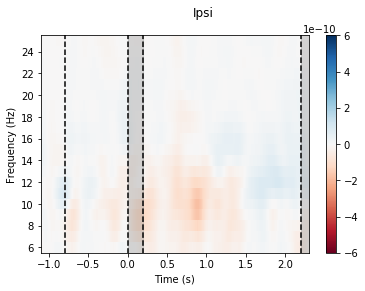

In [4]:
# %%
# Calc overall difference between high and low load:
load = 'LoadLow'
side = 'Ipsi'
ga = defaultdict(mne.EvokedArray)
for load in ['LoadLow', 'LoadHigh']:
    tmp = tfr_by_cond[load]
    ga[load] = mne.grand_average(tmp)

diff_ga_data = ga['LoadHigh'].data - ga['LoadLow'].data

info = ga['LoadHigh'].info
diff_ga = mne.time_frequency.AverageTFR(info, diff_ga_data, times, freqs, nave=21)

diff_diff = get_lateralized_power_difference(diff_ga, config.chans_CDA_dict['Contra'], 
                                                      config.chans_CDA_dict['Ipsi'])

fig, ax = plt.subplots(1, figsize=(6,4))
tf_contra = plot_tfr_side(ax, diff_diff, picks=config.chans_CDA_dict['Contra'], 
            tmin=-1.1, tmax=2.3, title=side, cbar=True, 
            vmin=-6e-10, vmax=6e-10)